In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
import tensorflow as tf
import numpy as np
import pandas as pd

# --- 1. YOUR FITNESS FUNCTION (Standalone) ---
def compute_niche_fitness(elementome_vals, my_centers, my_left, my_right, metric='chebyshev', sigma=40.0):
    """
    Computes fitness with a Sigma scaling factor.

    Args:
        sigma (float): The "Characteristic Scale" or "Tolerance Multiplier".
                       If sigma=1.0, the niche is strict (defined exactly by left/right).
                       If sigma=40.0, the niche is 40x wider (looser).
    """
    # Ensure inputs are tensors
    elementome_vals = tf.cast(elementome_vals, tf.float32)
    my_centers = tf.cast(my_centers, tf.float32)
    my_left    = tf.cast(my_left, tf.float32)
    my_right   = tf.cast(my_right, tf.float32)

    delta = elementome_vals - my_centers
    tolerance = tf.where(delta < 0, my_left, my_right)

    # 1. Normalize (Distance in "Tolerance Units")
    normalized_deviation = tf.abs(delta) / (tolerance + 1e-9)

    # Square of Sigma for the denominator
    sigma_sq = tf.square(sigma)

    if metric == "euclidean":
        # Sum of Squared Normalized Deviations
        sq = tf.square(normalized_deviation)
        ss = tf.reduce_sum(sq, axis=1)

        # SCALING APPLIED HERE: Divide by Sigma^2
        # Fitness = exp( -0.5 * (Dist / Sigma)^2 )
        niche_fitness = tf.exp(-0.5 * ss / sigma_sq)

    elif metric == 'chebyshev':
        max_dev = tf.reduce_max(normalized_deviation, axis=1)
        max_sq  = tf.square(max_dev)

        # SCALING APPLIED HERE
        niche_fitness = tf.exp(-2.3 * max_sq / sigma_sq)

    elif metric == "cosine":
        # NOTE: Sigma doesn't apply to Cosine (Angle) in the same way.
        # Cosine ignores magnitude distance completely.

        weights = 1.0 / (tf.square(tolerance) + 1e-9)
        numerator = tf.reduce_sum(weights * elementome_vals * my_centers, axis=1)

        norm_agent  = tf.sqrt(tf.reduce_sum(weights * tf.square(elementome_vals), axis=1))
        norm_center = tf.sqrt(tf.reduce_sum(weights * tf.square(my_centers), axis=1))

        similarity = numerator / (norm_agent * norm_center + 1e-9)
        niche_fitness = tf.pow(tf.maximum(0.0, similarity), 20.0)
    else:
        niche_fitness = tf.zeros(tf.shape(elementome_vals)[0])

    return tf.clip_by_value(niche_fitness, 0.0, 1.0)


# --- 2. DEFINE THE TEST SCENARIO ---

# A. The Species (The "Judge")
# Let's test against Spp 0 (The Nitrogen Lover)
spp0_center = np.array([0.4, 0.50, 0.1, 0.05, 0.05])
spp0_left   = np.array([0.2, 0.20, 0.1, 0.03, 0.03])
spp0_right  = np.array([0.1, 0.20, 0.1, 0.03, 0.03])

# B. The Agents (The "Contestants")
manual_agents = {
    "Perfect Match":   [0.4, 0.50, 0.1, 0.05, 0.05], # Exactly the center
    "Soil Default":    [0.4, 0.35, 0.1, 0.35, 0.10], # Based on your soil [0.35, 0.1, 0.35, 0.1]
    "Nitrogen Starved":[0.4, 0.10, 0.1, 0.05, 0.05], # Way too low N (0.1 vs 0.5)
    "Potassium Toxic": [0.4, 0.50, 0.1, 0.50, 0.05], # Perfect N, but K is huge (0.5 vs 0.05)
}

# Prepare Data for Function
agent_names = list(manual_agents.keys())
agent_data  = np.array(list(manual_agents.values())) # Shape (4, 5)

# Repeat Species Niche for each agent so shapes match
n_agents = len(agent_names)
centers_tiled = np.tile(spp0_center, (n_agents, 1))
left_tiled    = np.tile(spp0_left,   (n_agents, 1))
right_tiled   = np.tile(spp0_right,  (n_agents, 1))


# --- 3. RUN THE TEST ---
results = {}

for m in ['chebyshev', 'euclidean', 'cosine']:
    scores = compute_niche_fitness(
        agent_data,
        centers_tiled, left_tiled, right_tiled,
        metric=m
    ).numpy()
    results[m] = scores

# --- 4. DISPLAY RESULTS ---
df = pd.DataFrame(results, index=agent_names)
df = df.round(4) # Clean up decimals

print("--- FITNESS REPORT: Testing against Spp 0 (High N) ---")
print(f"Goal N: {spp0_center[1]}, Goal K: {spp0_center[3]}")
print("-" * 60)
print(df)

# Optional: Add a conclusion based on data
print("\n--- ANALYSIS ---")
print(f"1. Perfect Match should be 1.0 in all metrics. -> {df.loc['Perfect Match','chebyshev']}")
print(f"2. Soil Default (N=0.35 vs Goal=0.50):")
print(f"   - Chebyshev punishes hard (Limited by N deficit): {df.loc['Soil Default','chebyshev']}")
print(f"   - Euclidean is more forgiving (Averaging): {df.loc['Soil Default','euclidean']}")
print(f"3. K-Toxic (Perfect N, High K):")
print(f"   - Note how Cosine treats 'Toxic' levels (Direction vs Magnitude). Score: {df.loc['Potassium Toxic','cosine']}")


--- FITNESS REPORT: Testing against Spp 0 (High N) ---
Goal N: 0.5, Goal K: 0.05
------------------------------------------------------------
                  chebyshev  euclidean  cosine
Perfect Match        1.0000     1.0000  1.0000
Soil Default         0.8661     0.9682  0.0003
Nitrogen Starved     0.9943     0.9988  0.2282
Potassium Toxic      0.7237     0.9321  0.0000

--- ANALYSIS ---
1. Perfect Match should be 1.0 in all metrics. -> 1.0
2. Soil Default (N=0.35 vs Goal=0.50):
   - Chebyshev punishes hard (Limited by N deficit): 0.866100013256073
   - Euclidean is more forgiving (Averaging): 0.9682000279426575
3. K-Toxic (Perfect N, High K):
   - Note how Cosine treats 'Toxic' levels (Direction vs Magnitude). Score: 0.0


Calculated Sigma to hit target: 39.57


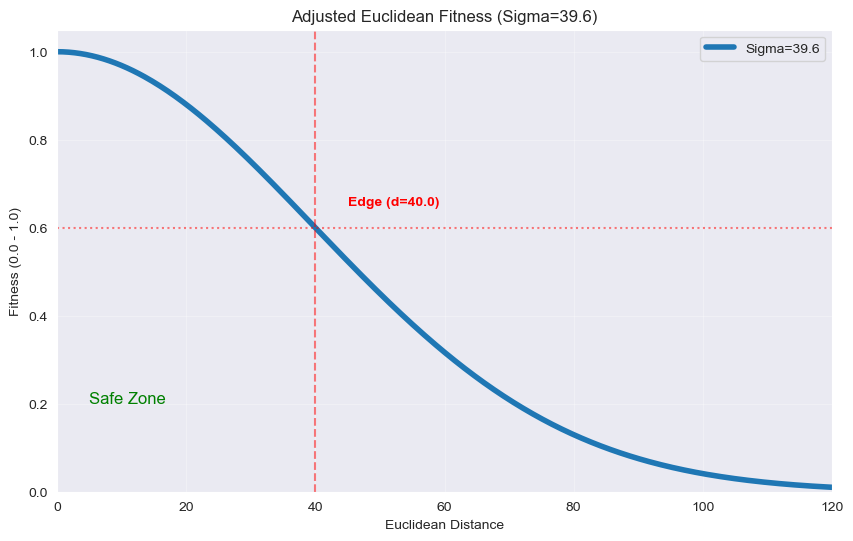

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Parameters ---
target_edge = 40.0    # You want fitness ~0.6 here
target_fitness = 0.6
max_dist = 150.0      # Plot range

# --- 2. Solve for Sigma ---
# Formula: F = exp(-0.5 * (d / sigma)^2)
# ln(F) = -0.5 * (d / sigma)^2
# sigma^2 = -0.5 * d^2 / ln(F)
# sigma = sqrt(-0.5 * d^2 / ln(F))

sigma_optimal = np.sqrt(-0.5 * target_edge**2 / np.log(target_fitness))

print(f"Calculated Sigma to hit target: {sigma_optimal:.2f}")

# --- 3. Generate Plot Data ---
distances = np.linspace(0.0, max_dist, 500)
fitness = np.exp(-0.5 * (distances / sigma_optimal)**2)

# --- 4. Plot ---
plt.figure(figsize=(10, 6))
plt.plot(distances, fitness, linewidth=4, color='tab:blue', label=f'Sigma={sigma_optimal:.1f}')

# --- 5. Annotations ---
plt.axvline(target_edge, color='red', linestyle='--', alpha=0.5)
plt.axhline(target_fitness, color='red', linestyle=':', alpha=0.5)

plt.text(5, 0.2, "Safe Zone", fontsize=12, color='green')
plt.text(target_edge + 5, 0.65, f"Edge (d={target_edge})", color='red', fontweight='bold')

plt.title(f"Adjusted Euclidean Fitness (Sigma={sigma_optimal:.1f})")
plt.xlabel("Euclidean Distance")
plt.ylabel("Fitness (0.0 - 1.0)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 120)
plt.ylim(0, 1.05)

plt.show()

Calculated Exponent to hit target: 3.33


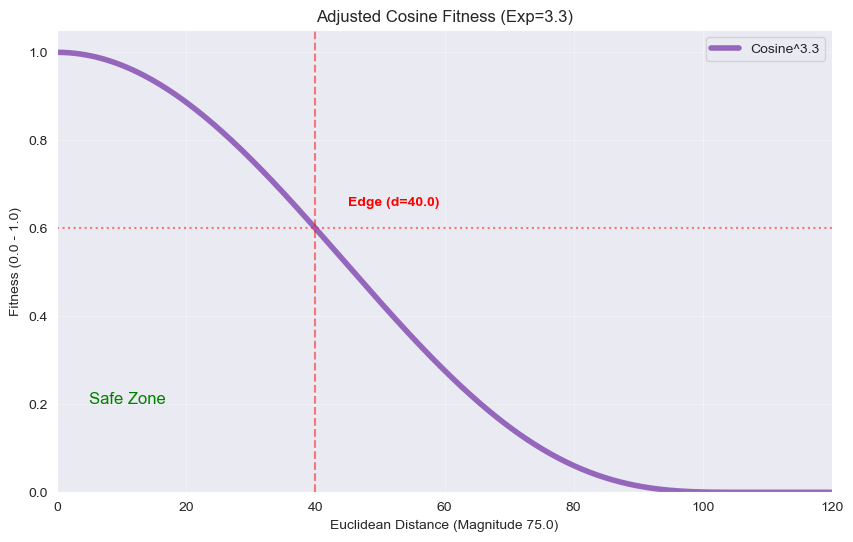

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Parameters ---
magnitude = 75.0      # Assumed total mass of an agent (Max dist = 150)
target_edge = 40.0    # You want fitness ~0.6 here
target_fitness = 0.6

# --- 2. Solve for the Exponent ---
# We calculate the Cosine Similarity at distance 40
# cos = 1 - d^2 / (2*M^2)
cos_at_40 = 1.0 - (target_edge**2 / (2 * magnitude**2))

# We want: cos^p = 0.6
# p * ln(cos) = ln(0.6)
# p = ln(0.6) / ln(cos)
optimal_exponent = np.log(target_fitness) / np.log(cos_at_40)

print(f"Calculated Exponent to hit target: {optimal_exponent:.2f}")

# --- 3. Generate Plot Data ---
distances = np.linspace(0.0, 150.0, 500)
cos_sim = 1.0 - (distances**2 / (2 * magnitude**2))
cos_sim = np.clip(cos_sim, -1.0, 1.0)

# Use the calculated exponent
fitness = np.power(np.maximum(0.0, cos_sim), optimal_exponent)

# --- 4. Plot ---
plt.figure(figsize=(10, 6))
plt.plot(distances, fitness, linewidth=4, color='tab:purple', label=f'Cosine^{optimal_exponent:.1f}')

# --- 5. Annotations ---
plt.axvline(target_edge, color='red', linestyle='--', alpha=0.5)
plt.axhline(target_fitness, color='red', linestyle=':', alpha=0.5)

plt.text(5, 0.2, "Safe Zone", fontsize=12, color='green')
plt.text(target_edge + 5, 0.65, f"Edge (d={target_edge})", color='red', fontweight='bold')

plt.title(f"Adjusted Cosine Fitness (Exp={optimal_exponent:.1f})")
plt.xlabel(f"Euclidean Distance (Magnitude {magnitude})")
plt.ylabel("Fitness (0.0 - 1.0)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 120)
plt.ylim(0, 1.05)

plt.show()
